# Rosenbrock Function Sensivity Analysis

## 1. Introduction

The present code evaluates the performance of the TuRBO algorithm in finding the minimum of the Rosenbrock function while varying:

- The number of trust regions (TR)
- The batch size
- The number of initial points per TR
- The dimensionality of the function

The performance will be evaluated as follows: three of this parameters will be kept constant, while one will be varied. The optimization process will be run on the function and the minimum value found will be recorded. Then, we will compare the values obtained for each value of the parameter. The maximum number of evaluations (`max_evals`) will be fixed at 1000. 

When not varied, the parameters will be fixed at:

- `n_trust_regions` = 5
- `batch_size` = 10
- `n_init` = 10 (20 on Turbo1)
- `dim` = 10

### 1.1 About the function

### Rosenbrock Function

The **Rosenbrock function** is a popular benchmark for gradient-based optimization algorithms. It is also known as the **"banana function"** due to the shape of its contours.  
While it looks simple, finding the global minimum is surprisingly difficult because it lies inside a long, narrow, parabolic valley. Algorithms easily find the valley but struggle to converge to the exact minimum within it.



The global minimum is located at:

$$x_i = 1 \text{ for all } i$$

with function value:

$$f(x) = 0$$

### Definition

For a $d$-dimensional vector $x = (x_1, \dots, x_d)$, the Rosenbrock function is defined as:

$$f(x) = \sum_{i=1}^{d-1} \left[ 100(x_{i+1} - x_i^2)^2 + (x_i - 1)^2 \right]$$

---

It is commonly evaluated over the domain:

$$x_i \in [-5, 5]$$

## 2. Pre-test codes

### 2.1 Imports

In [1]:
from turbo import TurboM 
from turbo import Turbo1
import numpy as np
import torch
import math
import matplotlib
import matplotlib.pyplot as plt

### 2.2 Rosenbrock Function Class

In [2]:
class Rosenbrock:
    def __init__(self, dim=10):
        self.dim = dim
        self.lb = -5 * np.ones(dim)
        self.ub = 5 * np.ones(dim)
        
    def __call__(self, x):
        assert len(x) == self.dim
        assert x.ndim == 1
        assert np.all(x <= self.ub) and np.all(x >= self.lb)
        
        xi = x[:-1]
        xnext = x[1:]
        
        val = np.sum(100.0 * (xnext - xi**2)**2 + (1.0 - xi)**2)
        return val

f = Rosenbrock(10)

## 3. Varying `n_trust_regions`

In [3]:
results_NTR = {
    "Turbo1": {},
    "TurboM": {}
}

### 3.1 One trust region (Turbo1)

In [4]:
turbo1 = Turbo1(
    f=f,  
    lb=f.lb,  
    ub=f.ub,  
    n_init=20,  
    max_evals = 1000,  
    batch_size=10,  
    verbose=False,  
    use_ard=True,  
    max_cholesky_size=2000,  
    n_training_steps=50,  
    min_cuda=1024,  
    device="cpu",  
    dtype="float64",  
)

turbo1.optimize()

X = turbo1.X  # Evaluated points
fX = turbo1.fX  # Observed values
ind_best = np.argmin(fX)

results_NTR["Turbo1"][1] = {
    "minimum_x": X[ind_best, :],
    "minimum_fX": fX[ind_best].item()
}

### 3.2 More trust regions (TurboM)

In [5]:
n_trust_regions_list = [2, 3, 5, 10]

for NTR in n_trust_regions_list:

    turbo_m = TurboM(
        f=f,  
        lb=f.lb,  
        ub=f.ub,  
        n_init=10,  
        max_evals=1000, 
        n_trust_regions=NTR, # Varying 
        batch_size=10,  
        verbose=False,  
        use_ard=True,  
        max_cholesky_size=2000,  
        n_training_steps=50, 
        min_cuda=1024,  
        device="cpu", 
        dtype="float64",  
    )

    turbo_m.optimize()

    X = turbo_m.X  # Evaluated points
    fX = turbo_m.fX  # Observed values
    ind_best = np.argmin(fX)

    results_NTR["TurboM"][NTR] = {
        "minimum_x": X[ind_best, :],
        "minimum_fX": fX[ind_best].item()
    }

In [6]:
minimum_fX_NTR = (
    [results_NTR["Turbo1"][1]["minimum_fX"]] +
    [results_NTR["TurboM"][n]["minimum_fX"] for n in results_NTR["TurboM"]]
)

In [7]:
print(minimum_fX_NTR)

[7.232440043924477, 11.495451673626896, 10.085062120205254, 56.24292850689219, 121.1108565015209]


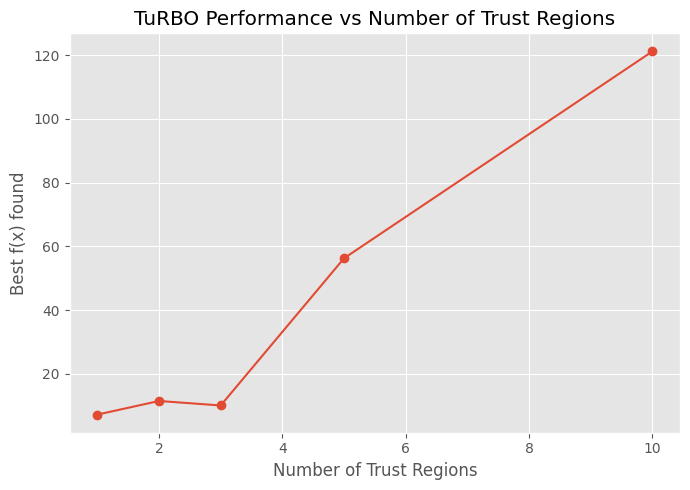

In [8]:
n_trust_regions_list_final = [1] + n_trust_regions_list

plt.style.use("ggplot")

fig = plt.figure(figsize=(7, 5))
plt.plot(n_trust_regions_list_final, minimum_fX_NTR, marker = 'o')  
plt.xlabel("Number of Trust Regions")
plt.ylabel("Best f(x) found")
plt.title("TuRBO Performance vs Number of Trust Regions")

plt.grid(True)
plt.tight_layout()
plt.show()

## 4. Varying the `batch_size`

In [9]:
results_BS = {
    "TurboM": {}
}

In [10]:
batch_size_list = [5, 10, 15, 20, 30, 50]

for BS in batch_size_list:

    turbo_m = TurboM(
        f=f,  
        lb=f.lb,  
        ub=f.ub,  
        n_init=10,  
        max_evals=1000, 
        n_trust_regions=5, 
        batch_size=BS,  # Varying
        verbose=False,  
        use_ard=True,  
        max_cholesky_size=2000,  
        n_training_steps=50, 
        min_cuda=1024,  
        device="cpu", 
        dtype="float64",  
    )

    turbo_m.optimize()

    X = turbo_m.X  # Evaluated points
    fX = turbo_m.fX  # Observed values
    ind_best = np.argmin(fX)

    results_BS["TurboM"][BS] = {
        "minimum_x": X[ind_best, :],
        "minimum_fX": fX[ind_best].item()
    }

In [11]:
minimum_fX_BS = [results_BS["TurboM"][n]["minimum_fX"] for n in results_BS["TurboM"]]

In [12]:
print(minimum_fX_BS)

[15.360515023217467, 23.25859999690264, 17.767337740746285, 24.637483634429948, 70.0076329683462, 88.93674142992472]


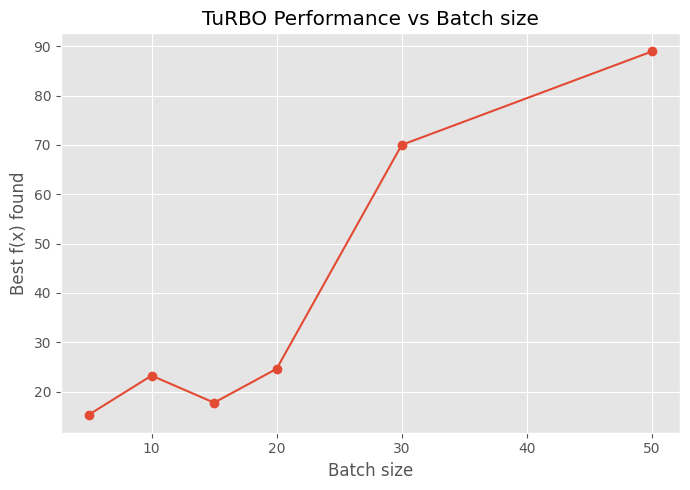

In [13]:
plt.style.use("ggplot")

fig = plt.figure(figsize=(7, 5))
plt.plot(batch_size_list, minimum_fX_BS, marker = 'o')   
plt.xlabel("Batch size")
plt.ylabel("Best f(x) found")
plt.title("TuRBO Performance vs Batch size")

plt.grid(True)
plt.tight_layout()
plt.show()

## 4. Varying `n_init`

In [14]:
results_NI = {
    "TurboM": {}
}

In [15]:
n_init_list = [5, 10, 15, 20, 30, 50]

for NI in n_init_list:

    turbo_m = TurboM(
        f=f,  
        lb=f.lb,  
        ub=f.ub,  
        n_init=10,  
        max_evals=1000, 
        n_trust_regions=5, 
        batch_size=NI, # Varying 
        verbose=False,  
        use_ard=True,  
        max_cholesky_size=2000,  
        n_training_steps=50, 
        min_cuda=1024,  
        device="cpu", 
        dtype="float64",  
    )

    turbo_m.optimize()

    X = turbo_m.X  # Evaluated points
    fX = turbo_m.fX  # Observed values
    ind_best = np.argmin(fX)

    results_NI["TurboM"][NI] = {
        "minimum_x": X[ind_best, :],
        "minimum_fX": fX[ind_best].item()
    }

In [16]:
minimum_fX_NI = [results_NI["TurboM"][n]["minimum_fX"] for n in results_NI["TurboM"]]

In [17]:
print(minimum_fX_NI)

[16.602422561034537, 11.892072798950721, 13.160190133608854, 8.92525623874387, 42.03738869601569, 109.8829279010974]


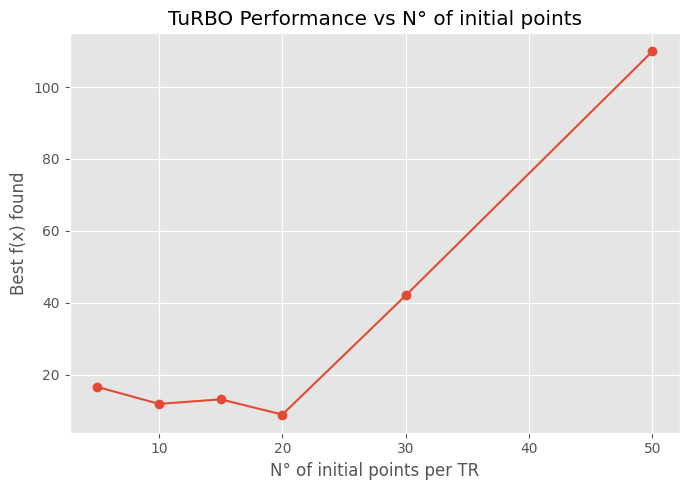

In [18]:
plt.style.use("ggplot")

fig = plt.figure(figsize=(7, 5))
plt.plot(n_init_list, minimum_fX_NI, marker = 'o')  
plt.xlabel("N° of initial points per TR")
plt.ylabel("Best f(x) found")
plt.title("TuRBO Performance vs N° of initial points")

plt.grid(True)
plt.tight_layout()
plt.show()

## 5. Varying dimensionality of the function

In [19]:
results_Dim = {
    "TurboM": {}
}

In [20]:
dimensionality_list = [2, 5, 10, 15, 20, 30]

for Dim in dimensionality_list:

    f = Rosenbrock(Dim) # Varying

    turbo_m = TurboM(
        f=f, # Here the dimensionality varies 
        lb=f.lb,  
        ub=f.ub,  
        n_init=10,  
        max_evals=1000, 
        n_trust_regions=5, 
        batch_size=10,
        verbose=False,  
        use_ard=True,  
        max_cholesky_size=2000,  
        n_training_steps=50, 
        min_cuda=1024,  
        device="cpu", 
        dtype="float64",  
    )

    turbo_m.optimize()

    X = turbo_m.X  # Evaluated points
    fX = turbo_m.fX  # Observed values
    ind_best = np.argmin(fX)

    results_Dim["TurboM"][Dim] = {
        "minimum_x": X[ind_best, :],
        "minimum_fX": fX[ind_best].item()
    }

In [21]:
minimum_fX_Dim = [results_Dim["TurboM"][n]["minimum_fX"] for n in results_Dim["TurboM"]]

In [22]:
print(minimum_fX_Dim)

[0.0023305035134093205, 1.9863824843976285, 15.607258051180334, 16.405257566025785, 104.27781480607689, 139.5585715227643]


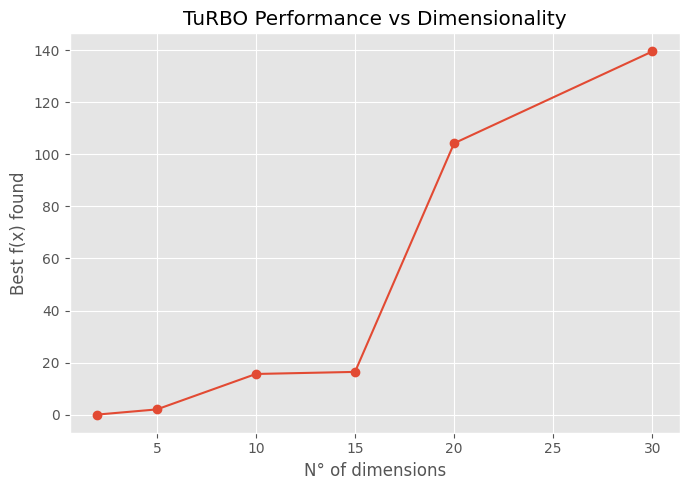

In [23]:
plt.style.use("ggplot")

fig = plt.figure(figsize=(7, 5))
plt.plot(dimensionality_list, minimum_fX_Dim, marker = 'o')  
plt.xlabel("N° of dimensions")
plt.ylabel("Best f(x) found")
plt.title("TuRBO Performance vs Dimensionality")

plt.grid(True)
plt.tight_layout()
plt.show()